In [1]:
import dill as pickle
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score,confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
df_all = pd.read_csv('data/df_all.csv', index_col=0)

In [3]:
df_all.describe(include='all')  

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
count,1732266,1.732266e+06,1732266,1732266,1.732266e+06,1732190,1732266,1536979,1428129,711514,1732266,718302,1385070,15062,1732266,1732266,1732266,1732266,1.732266e+06
unique,1732266,NaN,226,85032,NaN,280,55,406,280,1192,3,13,200,104,4947,55,159,2389,NaN
top,9055434745589932991.1637753792.1637753792,NaN,2021-05-24,13:00:00,NaN,ZpYIoDJMcFzVoPFsHGJL,banner,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Apple,AuMdmADEIoPXiWpTsBEj,414x896,Chrome,Russia,Moscow,NaN
freq,1,NaN,39230,58044,NaN,552555,525206,422992,935408,465950,1368679,425520,503533,9018,155140,951573,1682423,750928,NaN
mean,NaN,1.074577e+09,NaN,NaN,2.627835e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.904519e-02
std,NaN,6.201370e+08,NaN,NaN,1.164260e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.679333e-01
min,NaN,2.321640e+02,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,5.378943e+08,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
50%,NaN,1.074614e+09,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
75%,NaN,1.612130e+09,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00


In [4]:
print(df_all.shape)
print('Процент пропущенных значений:')
for col in df_all.columns:
    pct_missing = np.mean(df_all[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100, 3)))

(1732266, 19)
Процент пропущенных значений:
session_id - 0.0%
client_id - 0.0%
visit_date - 0.0%
visit_time - 0.0%
visit_number - 0.0%
utm_source - 0.004%
utm_medium - 0.0%
utm_campaign - 11.273%
utm_adcontent - 17.557%
utm_keyword - 58.926%
device_category - 0.0%
device_os - 58.534%
device_brand - 20.043%
device_model - 99.131%
device_screen_resolution - 0.0%
device_browser - 0.0%
geo_country - 0.0%
geo_city - 0.0%
target - 0.0%


In [5]:
#Убедимся в отсутствии дублей в колонке session_id (индексная колонка)
df_all.session_id.nunique()

1732266

# Анализ пропусков

1) Колонки utm_keyword, device_os, device_model нужно удалить из датасета -  пропусков больше 40%
2) client_id, session_id перед обучением тоже нужно будет удалить
3) Пропуски в оставшихся колонках заполним

## Колонки с пропусками

In [6]:
fields_with_na = ['utm_source','utm_campaign', 'utm_adcontent', 'device_brand']
for field in fields_with_na:
    print('Количество пропусков', field, ':', df_all[field].isna().sum())
    print('Количество уникальных значений', field, ':', df_all[field].nunique())
    print('Топ-10 уникальных значений',  field, ':', df_all[field].value_counts().iloc[0:10])

Количество пропусков utm_source : 76
Количество уникальных значений utm_source : 280
Топ-10 уникальных значений utm_source : utm_source
ZpYIoDJMcFzVoPFsHGJL    552555
fDLlAcSmythWSCVMvqvL    277060
kjsLglQLzykiRbcDiGcD    245178
MvfHsxITijuriZxsqZqt    175831
BHcvLfOaCWvWTykYqHVe    110963
bByPQxmDaMXgpHeypKSM     90356
QxAxdyPLuQMEcrdZWdWb     45267
aXQzDWsJuGXeBXexNHjc     29528
jaSOmLICuBzCFqHfBdRg     28288
RmEBuqrriAfAVsLQQmhk     27412
Name: count, dtype: int64
Количество пропусков utm_campaign : 195287
Количество уникальных значений utm_campaign : 406
Топ-10 уникальных значений utm_campaign : utm_campaign
LTuZkdKfxRGVceoWkVyg    422992
LEoPHuyFvzoNfnzGgfcd    321286
FTjNLDyTrXaWYgZymFkV    234950
gecBYcKZCPMcVYdSSzKP    133247
XHNUiSKKGTEpSAlaVMFQ     23750
sbJRYgVfvcnqKJNDDYIr     19942
okTXSMadDkjvntEHzIjp     18405
LwJZxKuWmvOhPsaCeRjG     16846
SgIUDYUKnyWHVowUOqid     15784
RoDitORHdzGfGhNCyEMy     15063
Name: count, dtype: int64
Количество пропусков utm_adcontent : 304137


### Комментарий
#### device_brand
Посмотрим, можем ли мы как-то заполнить пропуски более разумно- скорее всего, это поле связано с категорией устройства
#### utm_source , utm_campaign, utm_adcontent
Заполним пропуски значением 'other'

In [7]:
#device_brand
#Количество значений категории device_category=desktop - 366863 
#Проверим предположение о том, что  для desktop не заполнялась категория device_brand.
df_all[(df_all['device_brand'].isna()) & (df_all['device_category']=='desktop')].shape

(346752, 19)

In [8]:
#Предположение верное: почти все пропуски - там, где категория -desktop. 
#Заменим все пропуски соотвествующим значением device_category
df_all['device_brand'].fillna(df_all['device_category'], inplace = True)
df_all.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2.108383e+09,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,2.108385e+08,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2.108385e+09,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2.108386e+09,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2.108386e+09,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


In [9]:
#Обработка пропусков utm_campaign, utm_source и utm_adcontent
#Заполним пропуски значением 'other'
utm_na=['utm_adcontent','utm_campaign', 'utm_source']
for field in utm_na:
    df_all[field].fillna('other', inplace=True)

df_all.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2.108383e+09,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,2.108385e+08,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2.108385e+09,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2.108386e+09,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2.108386e+09,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


# Feature engineering

## device_screen_resolution -> device_scree_sqr


In [10]:
#device_screen_resolution
#попробуем сделать колонку с площадью экрана 
#Сначала посмотрим, есть ли значения, не удовлетворяющие формату 
df_all[~df_all['device_screen_resolution'].str.match(r'[0-9]+[x][0-9]+')]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target


In [11]:
#Таких значений нет, отлично
#Теперь мы можем посчитать площадь и заодно исправить тип на int
df_all['device_screen_sqr'] = df_all['device_screen_resolution'].apply(lambda x: int(x.split('x')[0]) * int(x.split('x')[1])) 
print(df_all.device_screen_sqr.dtype)
df_all.head()


int64


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target,device_screen_sqr
0,9055434745589932991.1637753792.1637753792,2.108383e+09,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0,259200
1,905544597018549464.1636867290.1636867290,2.108385e+08,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0,328790
2,9055446045651783499.1640648526.1640648526,2.108385e+09,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0,259200
3,9055447046360770272.1622255328.1622255328,2.108386e+09,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0,308898
4,9055447046360770272.1622255345.1622255345,2.108386e+09,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0,308898


In [12]:
#Полученных значений много, нужно проверить на выбросы
print('Количество уникальных значений device_screen_sqr: ', df_all['device_screen_sqr'].nunique())

Количество уникальных значений device_screen_sqr:  4506


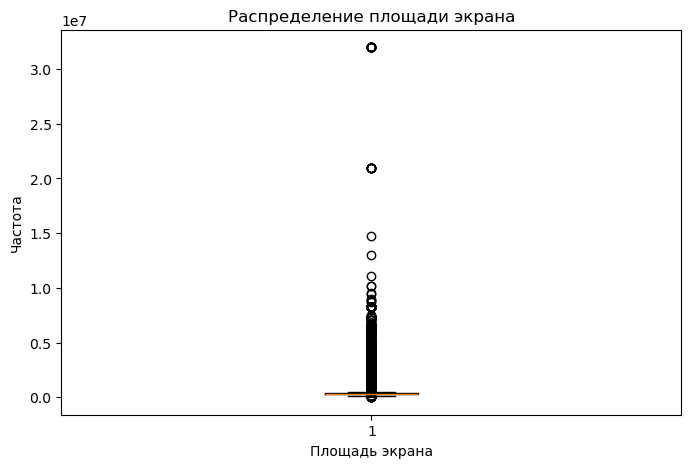

In [13]:
fig, (ax1) = plt.subplots(figsize=(8, 5))
ax1.boxplot(df_all.device_screen_sqr); 
ax1.set_xlabel('Площадь экрана')
ax1.set_ylabel('Частота')
plt.title('Распределение площади экрана');

In [14]:
df_all.device_screen_sqr.describe().apply(lambda x: f"{x:0.3f}")

count     1732266.000
mean       609144.794
std        705158.485
min             0.000
25%        280800.000
50%        334443.000
75%        376980.000
max      32000000.000
Name: device_screen_sqr, dtype: object

In [15]:
#Удалим выбросы

def delete_outliers(df, column):
    df_corr = df.copy()
    def calculate_outliers(data):
        q25 = data.quantile(0.25)
        q75 = data.quantile(0.75)
        iqr = q75 - q25
        boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

        return boundaries

    boundaries = calculate_outliers(df_corr[column])
    df_corr.loc[df[column] < boundaries[0], column] = round(boundaries[0])
    df_corr.loc[df[column] > boundaries[1], column] = round(boundaries[1])

    return df_corr

In [16]:
df_all =delete_outliers(df_all, 'device_screen_sqr')
df_all.device_screen_sqr.describe().apply(lambda x: f"{x:0.3f}")

count    1732266.000
mean      354464.604
std        97620.741
min       136530.000
25%       280800.000
50%       334443.000
75%       376980.000
max       521250.000
Name: device_screen_sqr, dtype: object

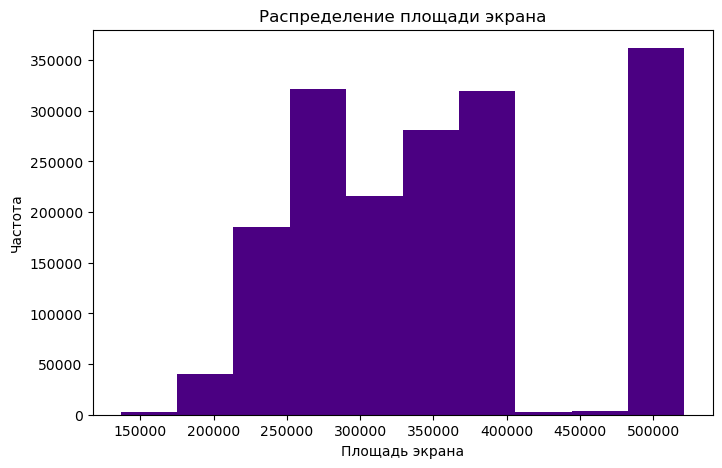

In [18]:
plt.figure(figsize=(8,5))

plt.hist(df_all.device_screen_sqr, color = 'indigo');
plt.xlabel('Площадь экрана')
plt.ylabel('Частота')
plt.title('Распределение площади экрана');

## device_browser - > device_browser_short
Уникальных значений много. Попробуем оставить во всех строках только первое слово

In [19]:
#device_browser
df_all['device_browser_short'] = df_all['device_browser'].apply(lambda x: x.split(' ')[0]) 
print('Уникальные значения: ', df_all['device_browser_short'].unique())
print('Распределение значений: ', df_all['device_browser_short'].value_counts())

Уникальные значения:  ['Chrome' 'Samsung' 'Safari' 'YaBrowser' 'Android' 'Opera' 'Firefox'
 'Edge' 'helloworld' 'UC' 'Instagram' 'Mozilla' '(not' 'Coc' '[FBAN'
 'Internet' 'Puffin' 'MRCHROME' 'com.vk.vkclient' 'Maxthon' 'Amazon'
 'SeaMonkey' 'MyApp' 'NetFront' 'MT6735_TD' 'NokiaX2-02' 'Nokia501'
 'com.zhiliaoapp.musically' 'Konqueror' 'Iron' 'Threads']
Распределение значений:  device_browser_short
Chrome                      951573
Safari                      502657
YaBrowser                   123765
Android                      52226
Samsung                      44273
Opera                        25117
Firefox                      15738
Edge                         15196
UC                             815
Mozilla                        352
Instagram                      218
[FBAN                          115
MRCHROME                        72
Puffin                          43
Maxthon                         30
Internet                        24
(not                            11
com.

## visit_time -> visit_hour

In [20]:
#visit_hour: оставим только час
df_all['visit_hour']=df_all['visit_time'].apply(lambda x: int(x.split(':')[0])) 
df_all['visit_hour'].value_counts()

visit_hour
14    104214
16     98462
15     96889
13     95835
18     94675
12     94612
17     94314
11     93683
10     93170
19     92030
20     91706
21     90647
22     87370
9      85359
23     79353
8      66933
0      62000
7      51140
1      37553
6      34119
2      25570
5      23765
3      19845
4      19022
Name: count, dtype: int64

In [21]:
#Посмотрим, в какие часы сколько было сессий, увенчавшихся успехом (target=1):
for i in range(24):
    print('Целевых действий в', i, ':', df_all[(df_all['visit_hour']==i) & (df_all['target']==1)].shape[0])

Целевых действий в 0 : 1886
Целевых действий в 1 : 1121
Целевых действий в 2 : 644
Целевых действий в 3 : 484
Целевых действий в 4 : 468
Целевых действий в 5 : 569
Целевых действий в 6 : 721
Целевых действий в 7 : 1194
Целевых действий в 8 : 1699
Целевых действий в 9 : 2317
Целевых действий в 10 : 2857
Целевых действий в 11 : 3083
Целевых действий в 12 : 3039
Целевых действий в 13 : 3230
Целевых действий в 14 : 3285
Целевых действий в 15 : 3080
Целевых действий в 16 : 3188
Целевых действий в 17 : 2959
Целевых действий в 18 : 2806
Целевых действий в 19 : 2483
Целевых действий в 20 : 2396
Целевых действий в 21 : 2388
Целевых действий в 22 : 2372
Целевых действий в 23 : 2045


In [22]:
#Попробуем сделать колонку "day_night": 23-08 отнесем к ночному времени, 09-22 - к дневному (значения - 1/0)
df_all['visit_day_night']=df_all['visit_hour'].apply(lambda x: 1 if (23>x>8) else 0)
df_all.head(10)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target,device_screen_sqr,device_browser_short,visit_hour,visit_day_night
0,9055434745589932991.1637753792.1637753792,2.108383e+09,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,NaN,360x720,Chrome,Russia,Zlatoust,0,259200,Chrome,14,1
1,905544597018549464.1636867290.1636867290,2.108385e+08,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,...,NaN,385x854,Samsung Internet,Russia,Moscow,0,328790,Samsung,8,0
2,9055446045651783499.1640648526.1640648526,2.108385e+09,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,NaN,360x720,Chrome,Russia,Krasnoyarsk,0,259200,Chrome,2,0
3,9055447046360770272.1622255328.1622255328,2.108386e+09,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,NaN,...,NaN,393x786,Chrome,Russia,Moscow,0,308898,Chrome,5,0
4,9055447046360770272.1622255345.1622255345,2.108386e+09,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,NaN,...,NaN,393x786,Chrome,Russia,Moscow,0,308898,Chrome,5,0
5,9055447192389856083.1622453074.1622453074,2.108386e+09,2021-05-31,12:00:00,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,...,NaN,375x812,Safari,Russia,Saint Petersburg,0,304500,Safari,12,1
6,9055455318486370642.1640843788.1640843788,2.108387e+09,2021-12-30,08:56:28,1,TxKUcPpthBDPieTGmVhx,cpc,FTjNLDyTrXaWYgZymFkV,LcGIUNPUAmXtQJaDfFBR,PwscUHjoUJDrtfWESIHj,...,NaN,602x1029,YaBrowser,Russia,Saint Petersburg,0,521250,YaBrowser,8,0
7,9055461992850812764.1626107740.1626107740,2.108389e+09,2021-07-12,19:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,...,NaN,360x640,Chrome,Russia,Saint Petersburg,0,230400,Chrome,19,1
8,9055462349345527315.1638536723.1638536723,2.108389e+09,2021-12-03,16:05:23,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,NaN,390x844,Safari,Russia,Moscow,0,329160,Safari,16,1
9,9055466554104774132.1624800757.1624800757,2.108390e+09,2021-06-27,16:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,...,NaN,412x915,Chrome,Russia,Moscow,0,376980,Chrome,16,1


## visit_date -> dayofweek

In [23]:
# Вместо даты возьмем день недели
df_all['visit_date']=pd.to_datetime(df_all['visit_date'])
df_all['dayofweek']= df_all['visit_date'].dt.dayofweek
df_all['dayofweek'].value_counts()


dayofweek
1    286998
0    281777
3    252240
4    248550
2    240941
5    211159
6    210601
Name: count, dtype: int64

In [24]:
#Проверим, отличается ли количество успешных сессий в разные дни недели
days=['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']
for i in range(len(days)):
    print('Целевых действий в', days[i], ':', df_all[(df_all['dayofweek']==i) & (df_all['target']==1)].shape[0])

Целевых действий в пн : 9467
Целевых действий в вт : 8679
Целевых действий в ср : 7274
Целевых действий в чт : 7232
Целевых действий в пт : 6555
Целевых действий в сб : 5573
Целевых действий в вс : 5534


Text(0.5, 1.0, 'Доля успешных сессий по дням недели')

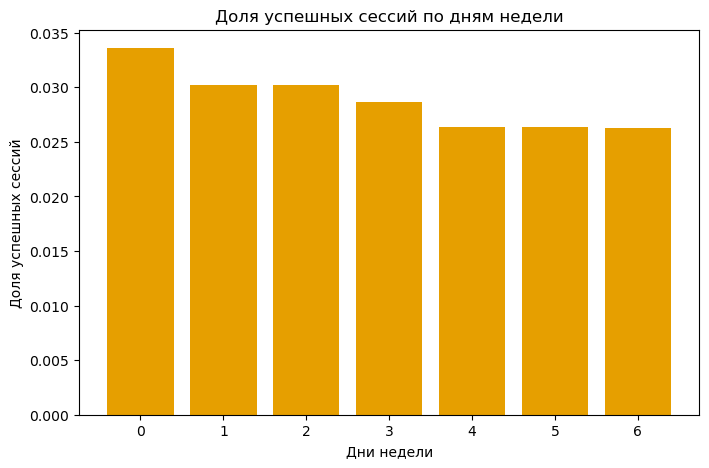

In [25]:
plt.figure(figsize=(8,5))

t1=df_all[df_all['target']==1].dayofweek.value_counts()
tfull=df_all.dayofweek.value_counts()

plt.bar(range(7), t1/tfull, color = '#E69F00')

plt.xlabel('Дни недели')
plt.ylabel('Доля успешных сессий')
plt.title('Доля успешных сессий по дням недели')

Вывод: по графику видно, что процент успешных сессий зависит от дня недели, а значит, этот параметр будет полезен для обучения.
По сути поле dayofweek по сути категориальное, но качество получается чуть-чуть лучше, если оставить его числовым, поэтому оставляем как есть.

## utm_fields -> utm_fields_freq

In [26]:
#Добавление новой числовой фичи - частота значения utm_поля
#Я пробовала добавить такие фичи для всех utm-полей, 
#но при добавлении всех 4х качество падает, а при добавлении двух - растет при градиентном бустинге.

freq_fields = ['utm_source','utm_campaign'] 
freq_list=[]
for field in freq_fields: 
    name = field+'_freq' 
    freq=df_all[field].value_counts().to_dict()
    freq_list.append(freq)
    df_all[name] = df_all[field].apply(lambda x: freq[x])

In [27]:
df_all.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,geo_country,geo_city,target,device_screen_sqr,device_browser_short,visit_hour,visit_day_night,dayofweek,utm_source_freq,utm_campaign_freq
0,9055434745589932991.1637753792.1637753792,2.108383e+09,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,Russia,Zlatoust,0,259200,Chrome,14,1,2,552555,321286
1,905544597018549464.1636867290.1636867290,2.108385e+08,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,...,Russia,Moscow,0,328790,Samsung,8,0,6,175831,234950
2,9055446045651783499.1640648526.1640648526,2.108385e+09,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,Russia,Krasnoyarsk,0,259200,Chrome,2,0,1,552555,321286
3,9055447046360770272.1622255328.1622255328,2.108386e+09,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,NaN,...,Russia,Moscow,0,308898,Chrome,5,0,5,245178,195287
4,9055447046360770272.1622255345.1622255345,2.108386e+09,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,NaN,...,Russia,Moscow,0,308898,Chrome,5,0,5,245178,195287


In [ ]:
# Сохраним полученные массивы для пайплайна
with open('freq.pkl', 'wb') as file:
    pickle.dump(freq_list, file)


Text(0.5, 1.0, 'Распределение часототы значений utm_campaign в успешных сессиях')

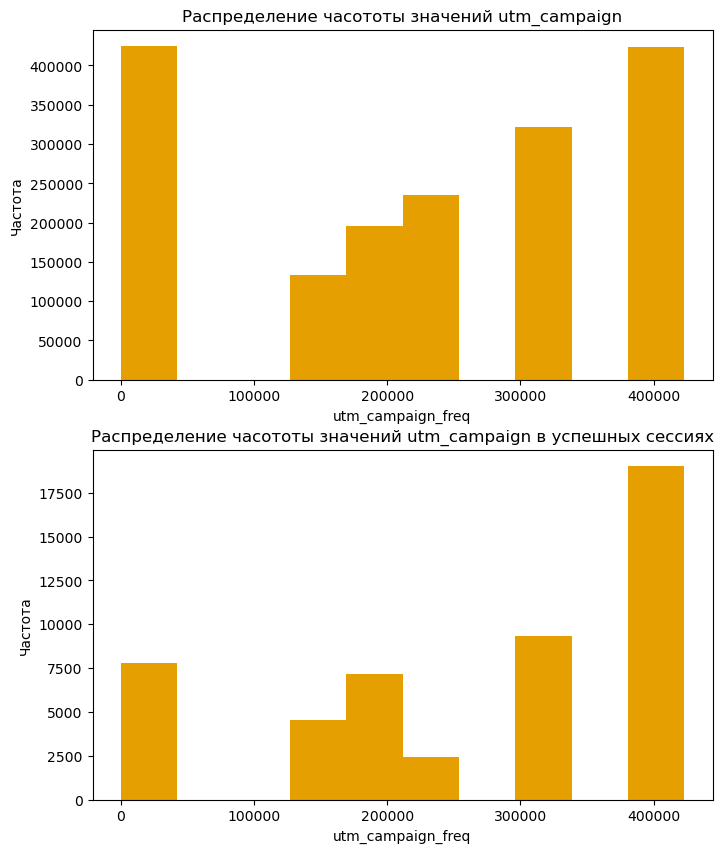

In [38]:
plt.figure(figsize=(8,10))
freq=df_all.utm_campaign_freq
plt.subplot(2,1,1)

plt.hist( freq, color = '#E69F00')
plt.xlabel('utm_campaign_freq')
plt.ylabel('Частота')
plt.title('Распределение часототы значений utm_campaign')

plt.subplot(2,1,2)
freq=df_all[df_all['target']==1].utm_campaign_freq
plt.hist( freq, color = '#E69F00')
plt.ylabel('Частота')
plt.xlabel('utm_campaign_freq')
plt.title('Распределение часототы значений utm_campaign в успешных сессиях')

По графикам видно, что распределение выглядит по-разному для успешных сессий и для всех сессий, а значит, фича будет полезна для обучения. 
Аналогичные графики для utm_source_freq тоже различаются:

Text(0.5, 1.0, 'Распределение часототы значений utm_souce в успешных сессиях')

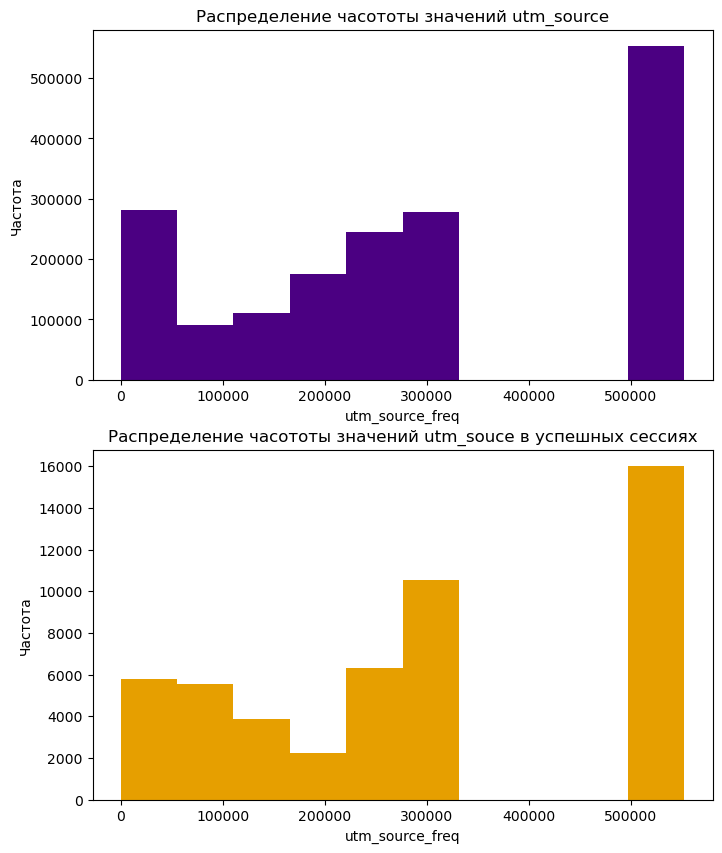

In [40]:
plt.figure(figsize=(8,10))
freq=df_all.utm_source_freq
plt.subplot(2,1,1)

plt.hist( freq, color = 'indigo')
plt.xlabel('utm_source_freq')
plt.ylabel('Частота')
plt.title('Распределение часототы значений utm_source')

plt.subplot(2,1,2)
freq=df_all[df_all['target']==1].utm_source_freq
plt.hist( freq, color = '#E69F00')
plt.ylabel('Частота')
plt.xlabel('utm_source_freq')
plt.title('Распределение часототы значений utm_souce в успешных сессиях')

## Тепловая карта для получившихся численных признаков

<Axes: title={'center': 'Корреляция численных признаков'}>

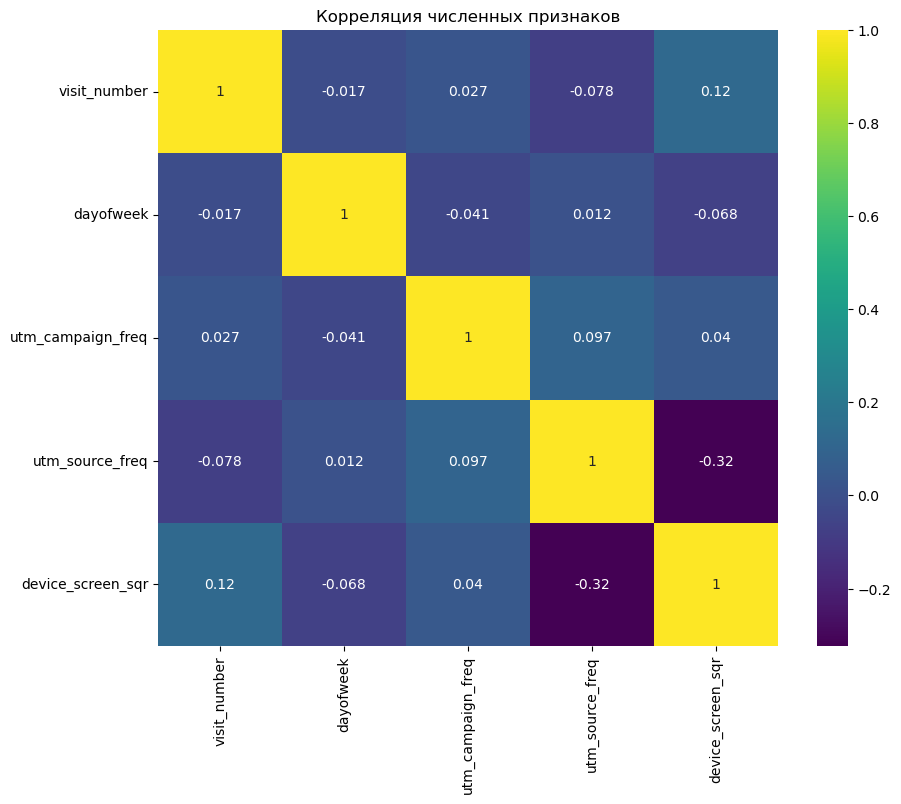

In [41]:
df_corr = df_all[['visit_number','dayofweek', 'utm_campaign_freq','utm_source_freq', 'device_screen_sqr']]

plt.figure(figsize=(10, 8))
plt.title("Корреляция численных признаков")
sns.heatmap(df_corr.corr(), annot=True, cmap= 'viridis')

Вывод: Тепловая карта не показывает никаких ярко-выраженных корреляций между числовыми переменными.

# Преобразование категориальных переменных с помощью OHE


In [42]:
df_all.columns.to_list()

['session_id',
 'client_id',
 'visit_date',
 'visit_time',
 'visit_number',
 'utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'utm_keyword',
 'device_category',
 'device_os',
 'device_brand',
 'device_model',
 'device_screen_resolution',
 'device_browser',
 'geo_country',
 'geo_city',
 'target',
 'device_screen_sqr',
 'device_browser_short',
 'visit_hour',
 'visit_day_night',
 'dayofweek',
 'utm_source_freq',
 'utm_campaign_freq']

In [43]:
df_all=df_all.copy()
categorical_features=['utm_source', 'utm_medium', 'device_category', 'device_brand', 
                      'geo_country', 'geo_city', 'device_browser_short', 'utm_adcontent','utm_campaign']

ohe = OneHotEncoder(sparse_output=False,handle_unknown = 'infrequent_if_exist', min_frequency= 0.005)
ohe.fit(df_all[categorical_features])
ohe_cat = ohe.transform(df_all[categorical_features])
df_all[ohe.get_feature_names_out()] = ohe_cat
df_all.head()

C:\Users\Yana Eliseeva\AppData\Local\Temp\ipykernel_18984\498933593.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[ohe.get_feature_names_out()] = ohe_cat
C:\Users\Yana Eliseeva\AppData\Local\Temp\ipykernel_18984\498933593.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[ohe.get_feature_names_out()] = ohe_cat
C:\Users\Yana Eliseeva\AppData\Local\Temp\ipykernel_18984\498933593.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,utm_campaign_bJJuEXRheRIxXEaYIXqM,utm_campaign_bxOTvPtyGSdUrbwoXCPO,utm_campaign_gecBYcKZCPMcVYdSSzKP,utm_campaign_nSReTmyFtbSjlPrTKoaX,utm_campaign_okTXSMadDkjvntEHzIjp,utm_campaign_other,utm_campaign_sbJRYgVfvcnqKJNDDYIr,utm_campaign_vRLTQQKAsFQMxbcHGPhu,utm_campaign_zxoiLxhuSIFrCeTLQVWZ,utm_campaign_infrequent_sklearn
0,9055434745589932991.1637753792.1637753792,2.108383e+09,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,905544597018549464.1636867290.1636867290,2.108385e+08,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9055446045651783499.1640648526.1640648526,2.108385e+09,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9055447046360770272.1622255328.1622255328,2.108386e+09,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,9055447046360770272.1622255345.1622255345,2.108386e+09,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [44]:
df_all.columns.to_list()

['session_id',
 'client_id',
 'visit_date',
 'visit_time',
 'visit_number',
 'utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'utm_keyword',
 'device_category',
 'device_os',
 'device_brand',
 'device_model',
 'device_screen_resolution',
 'device_browser',
 'geo_country',
 'geo_city',
 'target',
 'device_screen_sqr',
 'device_browser_short',
 'visit_hour',
 'visit_day_night',
 'dayofweek',
 'utm_source_freq',
 'utm_campaign_freq',
 'utm_source_BHcvLfOaCWvWTykYqHVe',
 'utm_source_MvfHsxITijuriZxsqZqt',
 'utm_source_PlbkrSYoHuZBWfYjYnfw',
 'utm_source_QxAxdyPLuQMEcrdZWdWb',
 'utm_source_RmEBuqrriAfAVsLQQmhk',
 'utm_source_ZpYIoDJMcFzVoPFsHGJL',
 'utm_source_aXQzDWsJuGXeBXexNHjc',
 'utm_source_bByPQxmDaMXgpHeypKSM',
 'utm_source_fDLlAcSmythWSCVMvqvL',
 'utm_source_fgymSoTvjKPEgaIJqsiH',
 'utm_source_gDBGzjFKYabGgSPZvrDH',
 'utm_source_hTjLvqNxGggkGnxSCaTm',
 'utm_source_jaSOmLICuBzCFqHfBdRg',
 'utm_source_kjsLglQLzykiRbcDiGcD',
 'utm_source_vFcAhRxLfOWKhvxjELkx',
 'utm_sou

# Скалирование числовых переменных с помощью  MinMaxScaler

## device_screen_sqr

In [45]:
df_screen=df_all[['device_screen_sqr']]
mm_scaler = MinMaxScaler()
mm_scaler.fit(df_screen)
mm_scaled = mm_scaler.transform(df_screen)
df_all['device_screen_sqr_mm'] = mm_scaled

df_all.head(5)

C:\Users\Yana Eliseeva\AppData\Local\Temp\ipykernel_18984\1546285141.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all['device_screen_sqr_mm'] = mm_scaled


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,utm_campaign_bxOTvPtyGSdUrbwoXCPO,utm_campaign_gecBYcKZCPMcVYdSSzKP,utm_campaign_nSReTmyFtbSjlPrTKoaX,utm_campaign_okTXSMadDkjvntEHzIjp,utm_campaign_other,utm_campaign_sbJRYgVfvcnqKJNDDYIr,utm_campaign_vRLTQQKAsFQMxbcHGPhu,utm_campaign_zxoiLxhuSIFrCeTLQVWZ,utm_campaign_infrequent_sklearn,device_screen_sqr_mm
0,9055434745589932991.1637753792.1637753792,2.108383e+09,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.318855
1,905544597018549464.1636867290.1636867290,2.108385e+08,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.499740
2,9055446045651783499.1640648526.1640648526,2.108385e+09,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.318855
3,9055447046360770272.1622255328.1622255328,2.108386e+09,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.448035
4,9055447046360770272.1622255345.1622255345,2.108386e+09,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.448035


# Удаление ненужных колонок и сохранение датасета

In [46]:
columns_to_drop=['session_id', 'client_id', 'visit_date', 'visit_time', 
                 'device_browser', 'utm_adcontent', 'utm_campaign', 'utm_keyword', 'device_os', 
                 'device_model', 'device_screen_resolution', 'device_screen_sqr', 'visit_hour'] + categorical_features


df_all_final=df_all.drop(columns_to_drop, axis=1)

In [47]:
df_all_final.to_csv('data/final_dataset.csv')
df_all_final.shape

(1732266, 110)

In [48]:
df_all_final.columns.to_list()

['visit_number',
 'target',
 'visit_day_night',
 'dayofweek',
 'utm_source_freq',
 'utm_campaign_freq',
 'utm_source_BHcvLfOaCWvWTykYqHVe',
 'utm_source_MvfHsxITijuriZxsqZqt',
 'utm_source_PlbkrSYoHuZBWfYjYnfw',
 'utm_source_QxAxdyPLuQMEcrdZWdWb',
 'utm_source_RmEBuqrriAfAVsLQQmhk',
 'utm_source_ZpYIoDJMcFzVoPFsHGJL',
 'utm_source_aXQzDWsJuGXeBXexNHjc',
 'utm_source_bByPQxmDaMXgpHeypKSM',
 'utm_source_fDLlAcSmythWSCVMvqvL',
 'utm_source_fgymSoTvjKPEgaIJqsiH',
 'utm_source_gDBGzjFKYabGgSPZvrDH',
 'utm_source_hTjLvqNxGggkGnxSCaTm',
 'utm_source_jaSOmLICuBzCFqHfBdRg',
 'utm_source_kjsLglQLzykiRbcDiGcD',
 'utm_source_vFcAhRxLfOWKhvxjELkx',
 'utm_source_infrequent_sklearn',
 'utm_medium_(none)',
 'utm_medium_banner',
 'utm_medium_cpc',
 'utm_medium_cpm',
 'utm_medium_email',
 'utm_medium_organic',
 'utm_medium_push',
 'utm_medium_referral',
 'utm_medium_stories',
 'utm_medium_infrequent_sklearn',
 'device_category_desktop',
 'device_category_mobile',
 'device_category_tablet',
 'device_bran